Forked from: https://www.kaggle.com/steamedsheep/yolov5-high-resolution-training but extensively modified using my private notebooks

# Yolov5 training with Albumentations

## Why this notebook?
* There are no notebooks that show how to integrate custom augmentations into the Yolov5 training pipeline
* Others bake the augmentations to the data prior to training.
* This notebook shows you how to apply augmentations from the Albumentations package on the fly using yolov5's Albumentations integration

# Log:
|version|config|
|-------|------|
|v1|img_size=3000,epoch=11,bs=2,val fold = 1|




## Modules Required

In [1]:
import warnings
warnings.filterwarnings("ignore")

import ast
import os
import json
import pandas as pd
import numpy as np
import torch
import importlib
import cv2 

import shutil
from shutil import copyfile, make_archive
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupKFold
from PIL import Image
from string import Template
from IPython.display import display

import matplotlib.pyplot as plt

TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'

# Yolov5 Setup and Albumentations

In [2]:
# !git clone https://github.com/ultralytics/yolov5.git
!git clone https://github.com/soumya997/yolov5-w-f2-mod.git
!mv ./yolov5-w-f2-mod ./yolov5

Cloning into 'yolov5-w-f2-mod'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 132 (delta 36), reused 120 (delta 26), pack-reused 0
Receiving objects: 100% (132/132), 1.39 MiB | 3.28 MiB/s, done.
Resolving deltas: 100% (36/36), done.


## Setting your custom Albumentations

In [4]:
# # Specify your custom set of Albumentations here
# # See https://www.kaggle.com/alexchwong/cots-albumentations-gallery for some ideas on what to include
# # Ensure there are at least 16 spaces after each new line, for correct indentations consistent with yolov5's augmentations.py script

# ################ 16 hashes here

# # ALBUMENTATIONS = '''[
# #                 # Add your Albumentations after this line
# #                     A.OneOf([
# #                         A.MotionBlur(p=.2),
# #                         A.MedianBlur(blur_limit=3, p=0.3),
# #                         A.Blur(blur_limit=3, p=0.1),
# #                     ], p=0.3),
# #                     A.OneOf([
# #                         A.CLAHE(clip_limit=2),
# #                         A.RandomBrightnessContrast(),            
# #                     ], p=0.3),
# #                 # Do not edit past this line
# #                 ],
# # # '''
# ALBUMENTATIONS = '''[
#                 # Add your Albumentations after this line
#                     A.OneOf([
#                         A.HueSaturationValue(hue_shift_limit = 0.2, 
#                                              sat_shift_limit = 0.2,
#                                              val_shift_limit = 0.2,
#                                              p = 0.3), 

#                         A.RandomBrightnessContrast(brightness_limit = 0.2,                                             
#                                                    contrast_limit = 0.2,
#                                                    p = 0.3),
#                         A.RGBShift(r_shift_limit = 20/255, 
#                                    g_shift_limit = 20/255, 
#                                    b_shift_limit = 10/255,
#                                    p = 0.3)
#                     ], 
#                     p = 0.2),
#                 A.OneOf([
#                             A.RandomGamma(gamma_limit = (80, 120),p = 0.3),
#                             A.Blur(p = 0.6),
#                             A.GaussNoise(var_limit = (0.01, 0.05), mean = 0, p = 0.05),
#                             A.ToGray(p = 0.05),
#                             A.Solarize(p=0.3)

#                         ],
#                         p = 0.1),
#                 A.ToGray(p=0.01),
#                 A.RandomFog(fog_coef_lower = 0.1,
#                                 fog_coef_upper = 0.2,
#                                 p = 0.03),          
#                 # Do not edit past this line
#                 ],
# '''

# ################ If you are not convinced whether your Albumentations are working, uncomment the following line to make all the training pictures gray at the end:

# # ALBUMENTATIONS = "[A.ToGray(p=1.0),],"


### Yolov5's hyperparameters file

In [5]:
# From yolov5/data/hyps/hyp.scratch.yaml

# Change yolov5's built-in augmentations / training hyperparameters here

hyps = '''

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

'''

# Define Model YAML for 1 class

In [6]:
# edit number of classes to 1
copyfile("/kaggle/working/yolov5/models/yolov5s.yaml", "/kaggle/working/yolov5/yolov5s.yaml")   
!sed -i 's/nc: 80/nc: 1/g' /kaggle/working/yolov5/yolov5s.yaml
!cat '/kaggle/working/yolov5/yolov5s.yaml'

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],

### Write yaml files

In [7]:
cots_data = '''
train: ../images/train
val: ../images/valid

nc: 1
names: [cots]
'''

In [8]:
with open('./yolov5/data/cots.yaml', 'w') as fp:
    fp.write(cots_data)
with open('./yolov5/data/hyps/hyps_custom.yaml', 'w') as fp:
    fp.write(hyps)

### Bake your custom albumentations into Yolov5's augmentations.py script

In [9]:
# augmentations_template = '''
# # YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# """
# Image augmentation functions
# """

# import math
# import random

# import cv2
# import numpy as np

# from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box
# from utils.metrics import bbox_ioa


# class Albumentations:
#     # YOLOv5 Albumentations class (optional, only used if package is installed)
#     def __init__(self):
#         self.transform = None
#         try:
#             import albumentations as A
#             # check_version(A.__version__, '1.0.3', hard=True)  # version requirement

#             self.transform = A.Compose($albumentations
#                 bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

#             LOGGER.info(colorstr('albumentations: ') + ', '.join(f'{x}' for x in self.transform.transforms if x.p))
#         except ImportError:  # package not installed, skip
#             pass
#         except Exception as e:
#             LOGGER.info(colorstr('albumentations: ') + f'{e}')

#     def __call__(self, im, labels, p=1.0):
#         if self.transform and random.random() < p:
#             new = self.transform(image=im, bboxes=labels[:, 1:], class_labels=labels[:, 0])  # transformed
#             im, labels = new['image'], np.array([[c, *b] for c, b in zip(new['class_labels'], new['bboxes'])])
#         return im, labels


# def augment_hsv(im, hgain=0.5, sgain=0.5, vgain=0.5):
#     # HSV color-space augmentation
#     if hgain or sgain or vgain:
#         r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
#         hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
#         dtype = im.dtype  # uint8

#         x = np.arange(0, 256, dtype=r.dtype)
#         lut_hue = ((x * r[0]) % 180).astype(dtype)
#         lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
#         lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

#         im_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
#         cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=im)  # no return needed


# def hist_equalize(im, clahe=True, bgr=False):
#     # Equalize histogram on BGR image 'im' with im.shape(n,m,3) and range 0-255
#     yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV if bgr else cv2.COLOR_RGB2YUV)
#     if clahe:
#         c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#         yuv[:, :, 0] = c.apply(yuv[:, :, 0])
#     else:
#         yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])  # equalize Y channel histogram
#     return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR if bgr else cv2.COLOR_YUV2RGB)  # convert YUV image to RGB


# def replicate(im, labels):
#     # Replicate labels
#     h, w = im.shape[:2]
#     boxes = labels[:, 1:].astype(int)
#     x1, y1, x2, y2 = boxes.T
#     s = ((x2 - x1) + (y2 - y1)) / 2  # side length (pixels)
#     for i in s.argsort()[:round(s.size * 0.5)]:  # smallest indices
#         x1b, y1b, x2b, y2b = boxes[i]
#         bh, bw = y2b - y1b, x2b - x1b
#         yc, xc = int(random.uniform(0, h - bh)), int(random.uniform(0, w - bw))  # offset x, y
#         x1a, y1a, x2a, y2a = [xc, yc, xc + bw, yc + bh]
#         im[y1a:y2a, x1a:x2a] = im[y1b:y2b, x1b:x2b]  # im4[ymin:ymax, xmin:xmax]
#         labels = np.append(labels, [[labels[i, 0], x1a, y1a, x2a, y2a]], axis=0)

#     return im, labels


# def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
#     # Resize and pad image while meeting stride-multiple constraints
#     shape = im.shape[:2]  # current shape [height, width]
#     if isinstance(new_shape, int):
#         new_shape = (new_shape, new_shape)

#     # Scale ratio (new / old)
#     r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
#     if not scaleup:  # only scale down, do not scale up (for better val mAP)
#         r = min(r, 1.0)

#     # Compute padding
#     ratio = r, r  # width, height ratios
#     new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
#     dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
#     if auto:  # minimum rectangle
#         dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
#     elif scaleFill:  # stretch
#         dw, dh = 0.0, 0.0
#         new_unpad = (new_shape[1], new_shape[0])
#         ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

#     dw /= 2  # divide padding into 2 sides
#     dh /= 2

#     if shape[::-1] != new_unpad:  # resize
#         im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
#     top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
#     left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
#     im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
#     return im, ratio, (dw, dh)


# def random_perspective(im, targets=(), segments=(), degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0,
#                        border=(0, 0)):
#     # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10))
#     # targets = [cls, xyxy]

#     height = im.shape[0] + border[0] * 2  # shape(h,w,c)
#     width = im.shape[1] + border[1] * 2

#     # Center
#     C = np.eye(3)
#     C[0, 2] = -im.shape[1] / 2  # x translation (pixels)
#     C[1, 2] = -im.shape[0] / 2  # y translation (pixels)

#     # Perspective
#     P = np.eye(3)
#     P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
#     P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

#     # Rotation and Scale
#     R = np.eye(3)
#     a = random.uniform(-degrees, degrees)
#     # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
#     s = random.uniform(1 - scale, 1 + scale)
#     # s = 2 ** random.uniform(-scale, scale)
#     R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

#     # Shear
#     S = np.eye(3)
#     S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
#     S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

#     # Translation
#     T = np.eye(3)
#     T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
#     T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

#     # Combined rotation matrix
#     M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
#     if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
#         if perspective:
#             im = cv2.warpPerspective(im, M, dsize=(width, height), borderValue=(114, 114, 114))
#         else:  # affine
#             im = cv2.warpAffine(im, M[:2], dsize=(width, height), borderValue=(114, 114, 114))

#     # Visualize
#     # import matplotlib.pyplot as plt
#     # ax = plt.subplots(1, 2, figsize=(12, 6))[1].ravel()
#     # ax[0].imshow(im[:, :, ::-1])  # base
#     # ax[1].imshow(im2[:, :, ::-1])  # warped

#     # Transform label coordinates
#     n = len(targets)
#     if n:
#         use_segments = any(x.any() for x in segments)
#         new = np.zeros((n, 4))
#         if use_segments:  # warp segments
#             segments = resample_segments(segments)  # upsample
#             for i, segment in enumerate(segments):
#                 xy = np.ones((len(segment), 3))
#                 xy[:, :2] = segment
#                 xy = xy @ M.T  # transform
#                 xy = xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]  # perspective rescale or affine

#                 # clip
#                 new[i] = segment2box(xy, width, height)

#         else:  # warp boxes
#             xy = np.ones((n * 4, 3))
#             xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
#             xy = xy @ M.T  # transform
#             xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

#             # create new boxes
#             x = xy[:, [0, 2, 4, 6]]
#             y = xy[:, [1, 3, 5, 7]]
#             new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

#             # clip
#             new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
#             new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)

#         # filter candidates
#         i = box_candidates(box1=targets[:, 1:5].T * s, box2=new.T, area_thr=0.01 if use_segments else 0.10)
#         targets = targets[i]
#         targets[:, 1:5] = new[i]

#     return im, targets


# def copy_paste(im, labels, segments, p=0.5):
#     # Implement Copy-Paste augmentation https://arxiv.org/abs/2012.07177, labels as nx5 np.array(cls, xyxy)
#     n = len(segments)
#     if p and n:
#         h, w, c = im.shape  # height, width, channels
#         im_new = np.zeros(im.shape, np.uint8)
#         for j in random.sample(range(n), k=round(p * n)):
#             l, s = labels[j], segments[j]
#             box = w - l[3], l[2], w - l[1], l[4]
#             ioa = bbox_ioa(box, labels[:, 1:5])  # intersection over area
#             if (ioa < 0.30).all():  # allow 30% obscuration of existing labels
#                 labels = np.concatenate((labels, [[l[0], *box]]), 0)
#                 segments.append(np.concatenate((w - s[:, 0:1], s[:, 1:2]), 1))
#                 cv2.drawContours(im_new, [segments[j].astype(np.int32)], -1, (255, 255, 255), cv2.FILLED)

#         result = cv2.bitwise_and(src1=im, src2=im_new)
#         result = cv2.flip(result, 1)  # augment segments (flip left-right)
#         i = result > 0  # pixels to replace
#         # i[:, :] = result.max(2).reshape(h, w, 1)  # act over ch
#         im[i] = result[i]  # cv2.imwrite('debug.jpg', im)  # debug

#     return im, labels, segments


# def cutout(im, labels, p=0.5):
#     # Applies image cutout augmentation https://arxiv.org/abs/1708.04552
#     if random.random() < p:
#         h, w = im.shape[:2]
#         scales = [0.5] * 1 + [0.25] * 2 + [0.125] * 4 + [0.0625] * 8 + [0.03125] * 16  # image size fraction
#         for s in scales:
#             mask_h = random.randint(1, int(h * s))  # create random masks
#             mask_w = random.randint(1, int(w * s))

#             # box
#             xmin = max(0, random.randint(0, w) - mask_w // 2)
#             ymin = max(0, random.randint(0, h) - mask_h // 2)
#             xmax = min(w, xmin + mask_w)
#             ymax = min(h, ymin + mask_h)

#             # apply random color mask
#             im[ymin:ymax, xmin:xmax] = [random.randint(64, 191) for _ in range(3)]

#             # return unobscured labels
#             if len(labels) and s > 0.03:
#                 box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
#                 ioa = bbox_ioa(box, labels[:, 1:5])  # intersection over area
#                 labels = labels[ioa < 0.60]  # remove >60% obscured labels

#     return labels


# def mixup(im, labels, im2, labels2):
#     # Applies MixUp augmentation https://arxiv.org/pdf/1710.09412.pdf
#     r = np.random.beta(32.0, 32.0)  # mixup ratio, alpha=beta=32.0
#     im = (im * r + im2 * (1 - r)).astype(np.uint8)
#     labels = np.concatenate((labels, labels2), 0)
#     return im, labels


# def box_candidates(box1, box2, wh_thr=2, ar_thr=100, area_thr=0.1, eps=1e-16):  # box1(4,n), box2(4,n)
#     # Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio
#     w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
#     w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
#     ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))  # aspect ratio
#     return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + eps) > area_thr) & (ar < ar_thr)  # candidates

# '''

# augmentations = Template(augmentations_template).substitute(
#     albumentations = ALBUMENTATIONS,
# )

# with open('/kaggle/working/yolov5/utils/augmentations.py', 'w') as f:
#     f.write(augmentations)

# !cat /kaggle/working/yolov5/utils/augmentations.py

## Data Prep

* This data prep uses 5-fold split using "sequence"
* Fold 4 is used as validation dataset

In [10]:
# Control Panel

N_FOLDS = 5
VALIDATION_FOLD = 1

In [11]:
TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [12]:
# hide

def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    for bbox in bboxes:
        if bbox[0] + bbox[2] >= image_width:
            bbox[2] = image_width - bbox[0] - 1
        if bbox[1] + bbox[3] >= image_height:
            bbox[3] = image_height - bbox[1] - 1
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

In [13]:
df = pd.read_csv("/kaggle/input/tensorflow-great-barrier-reef/train.csv")

# Taken only annotated photos
df["num_bbox"] = df['annotations'].apply(lambda x: str.count(x, 'x'))
df_train = df[df["num_bbox"]>0]

# Annotations 
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)

# Images resolution
df_train["width"] = 1280
df_train["height"] = 720

#Path of images
df_train = df_train.progress_apply(get_path, axis=1)

  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

In [14]:
kf = GroupKFold(n_splits = N_FOLDS) 
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
#     print(df_train.loc[val_idx, 'fold'])
    df_train.loc[val_idx, 'fold'] = fold

df_train.head(5)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bbox,bboxes,width,height,image_path,fold
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1,"[[559, 213, 50, 32]]",1280,720,/kaggle/input/tensorflow-great-barrier-reef/tr...,4
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1,"[[558, 213, 50, 32]]",1280,720,/kaggle/input/tensorflow-great-barrier-reef/tr...,4
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1,"[[557, 213, 50, 32]]",1280,720,/kaggle/input/tensorflow-great-barrier-reef/tr...,4
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1,"[[556, 214, 50, 32]]",1280,720,/kaggle/input/tensorflow-great-barrier-reef/tr...,4
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1,"[[555, 214, 50, 32]]",1280,720,/kaggle/input/tensorflow-great-barrier-reef/tr...,4


In [15]:
df_train["fold"].value_counts()

0    1100
3     970
2     968
4     945
1     936
Name: fold, dtype: int64

In [16]:
IMAGE_DIR = "/kaggle/working/images"
LABEL_DIR = "/kaggle/working/labels"

!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

!mkdir -p {IMAGE_DIR + '/train'}
!mkdir -p {IMAGE_DIR + '/valid'}
!mkdir -p {LABEL_DIR + '/train'}
!mkdir -p {LABEL_DIR + '/valid'}

def writeLabels(bboxes, destfile, image_width = 1280, image_height = 720):
    bboxes_coco  = np.array(bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots'] * num_bbox
    labels       = [0] * num_bbox
    with open(destfile, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
        else:
            bboxes_yolo  = coco2yolo(image_height, image_width, bboxes_coco)
            for bbox_idx in range(len(bboxes_yolo)):
                annot = [str(labels[bbox_idx])]+ list(bboxes_yolo[bbox_idx].astype(str))+(['\n'] if num_bbox!=(bbox_idx+1) else [''])
                annot = ' '.join(annot)
                annot = annot.strip(' ')
                f.write(annot)
    return ''

df1 = df_train[df_train.fold != VALIDATION_FOLD]
for row_idx in tqdm(range(len(df1))):
    row = df1.iloc[row_idx]
    shutil.copyfile(row.image_path, f'{IMAGE_DIR}/train/{row.image_id}.jpg')
    writeLabels(row.bboxes, f'{LABEL_DIR}/train/{row.image_id}.txt')

df2 = df_train[df_train.fold == VALIDATION_FOLD]
for row_idx in tqdm(range(len(df2))):
    row = df2.iloc[row_idx]
    shutil.copyfile(row.image_path, f'{IMAGE_DIR}/valid/{row.image_id}.jpg')
    writeLabels(row.bboxes, f'{LABEL_DIR}/valid/{row.image_id}.txt')

  0%|          | 0/3983 [00:00<?, ?it/s]

  0%|          | 0/936 [00:00<?, ?it/s]

# Training the Model

In [17]:
%cd yolov5

/kaggle/working/yolov5


### For demo purposes, only 1 epoch of yolov5s trained @ 1280p to make this notebook run quickly

In [18]:
!python -m wandb disabled

!python train.py \
    --img 3000 \
    --batch 2 \
    --epochs 11 \
    --data data/cots.yaml \
    --cfg yolov5s.yaml \
    --weights yolov5s.pt \
    --name cots_with_albs \
    --hyp data/hyps/hyps_custom.yaml \
    --save-period 1

W&B disabled.
100%|██████████████████████████████████████| 14.0M/14.0M [00:01<00:00, 10.6MB/s]

train: Scanning '../labels/train' images and labels...3983 found, 0 missing, 0 e
val: Scanning '../labels/valid' images and labels...936 found, 0 missing, 0 empt
      0/10     9.53G   0.07118   0.08562         0         1      3008: 100%|███
               Class     Images     Labels          P          R         F2     
      1/10     9.54G   0.05145   0.05008         0         8      3008: 100%|███
               Class     Images     Labels          P          R         F2     
      2/10     9.54G   0.04561   0.04296         0         4      3008: 100%|███
               Class     Images     Labels          P          R         F2     
      3/10     9.54G   0.03969   0.03844         0        10      3008: 100%|███
               Class     Images     Labels          P          R         F2     
      4/10     9.54G   0.03543   0.03411         0         3      3008: 100%|███
             

In [19]:
# sdjbfjksbdfkjb

<!-- ucvgkcvigvuyvoluyvbhlo -->

# View your Albumentations

In [20]:
TRAIN_RUN_DIR = "/kaggle/working/yolov5/runs/train/cots_with_albs"

In [21]:
!ls {TRAIN_RUN_DIR}

F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1644069945.ba5c82521a91.125.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


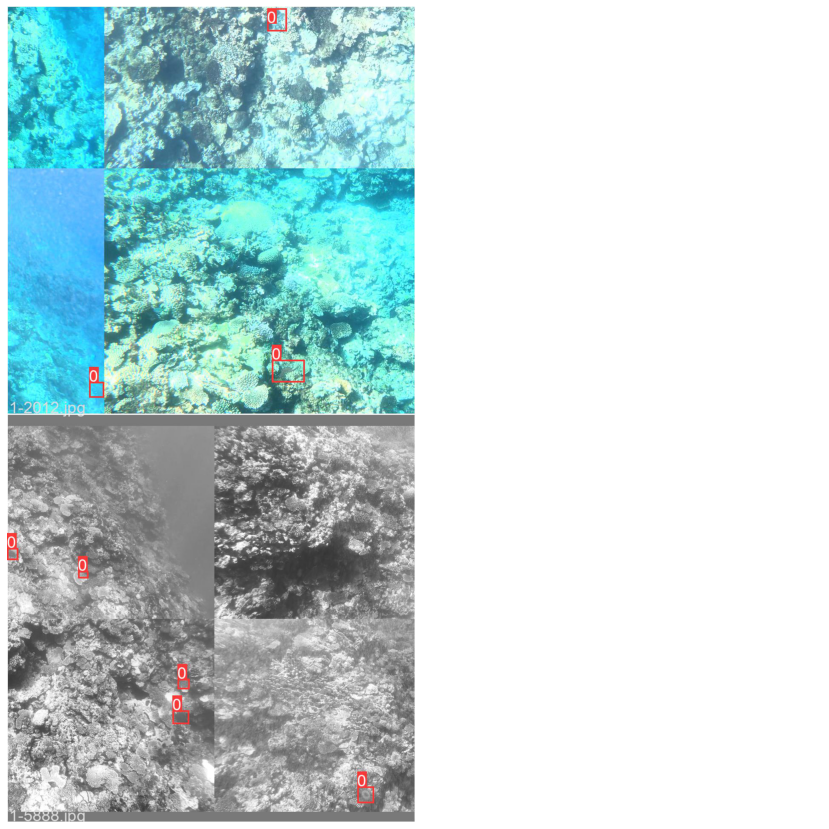

In [22]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{TRAIN_RUN_DIR}/train_batch0.jpg'));

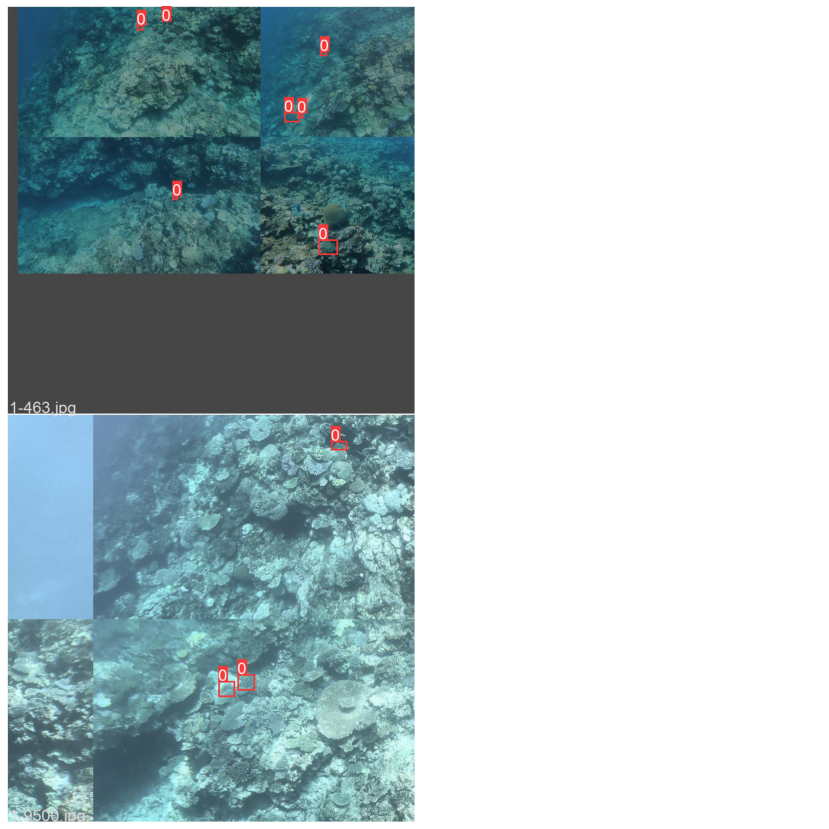

In [23]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{TRAIN_RUN_DIR}/train_batch1.jpg'));

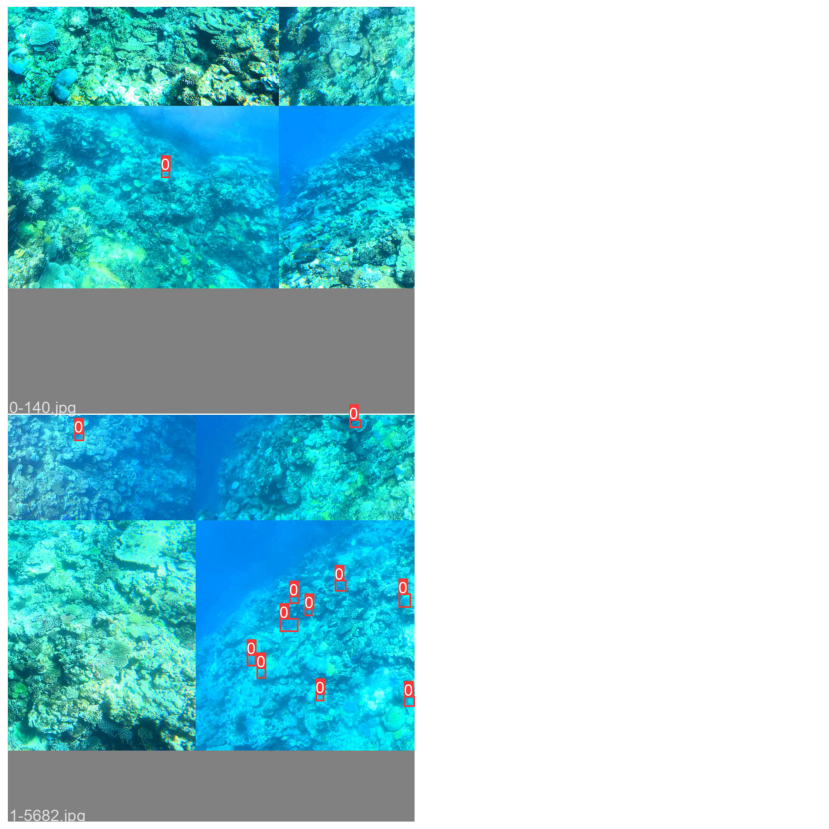

In [24]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{TRAIN_RUN_DIR}/train_batch2.jpg'));

## Cleanup

In [25]:
%cd /kaggle/working

!cp -r /kaggle/working/yolov5/runs/train/cots_with_albs /kaggle/working

!cp /kaggle/working/yolov5/data/cots.yaml /kaggle/working/cots_with_albs/
!cp /kaggle/working/yolov5/data/hyps/hyps_custom.yaml /kaggle/working/cots_with_albs/
!cp /kaggle/working/yolov5/utils/augmentations.py /kaggle/working/cots_with_albs/

!rm -r /kaggle/working/yolov5
!rm -r /kaggle/working/images
!rm -r /kaggle/working/labels

/kaggle/working
